In [1]:
import sys; sys.path.append('..'); from wwa import *

Xn, Xx, Yn, Yx = [-67,-47,-27,-7]
xn, xx, yn, yx = [-60,-54,-23,-15]
mapproj = cartopy.crs.PlateCarree()

In [2]:
sf = gpd.read_file("sf/pantanal")

In [3]:
days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

---
# Fire activity

## Cumulative fire activity

In [33]:
px_daily = pd.read_csv("data/modis-active-pixels_pantanal.csv", index_col = "acq_date", parse_dates = ["acq_date"])

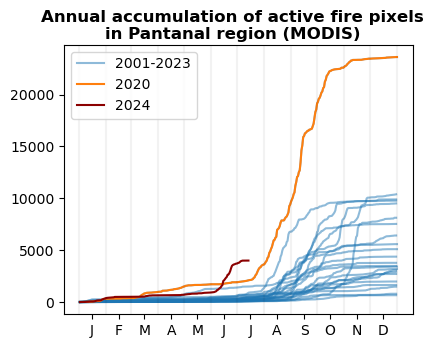

In [34]:
fig, ax = plt.subplots(figsize = (4.5,3.5), dpi = 100)

y = 2001
ts_y = px_daily.loc[str(y)]
ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), color = "tab:blue", alpha = 0.5, label = "2001-2023")

for y in range(2002,2024):
    ts_y = px_daily.loc[str(y)]
    ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), color = "tab:blue", alpha = 0.5, label = "_years")
    
y = 2020
ts_y = px_daily.loc[str(y)]
ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), color = "tab:orange", label = "2020")

y = 2024
ts_y = px_daily.loc[str(y)]
ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), color = "darkred", label = "2024")

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)

[ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]

plt.suptitle("Annual accumulation of active fire pixels\nin Pantanal region (MODIS)", fontweight = "bold")

ax.legend()

plt.savefig("fig/cum_modis-pixels.png")

## Correlation between DSR & fire activity

In [4]:
dsr_era5 = xr.open_dataset("data/fwi_daily_pantanal_era5.nc").dsr.resample(time = "MS").sum().sel(time = slice(None, "2024-06"))

px_monthly = pd.read_csv("data/modis-active-pixels_pantanal.csv", index_col = "acq_date", parse_dates = ["acq_date"]).resample("MS").sum().loc[slice(None, "2024-06")]

In [5]:
df = merge_byindex([dsr_era5.to_dataframe(), px_monthly]).dropna(axis = 0, how = "any")
df["log_px"] = np.log(df.px)

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


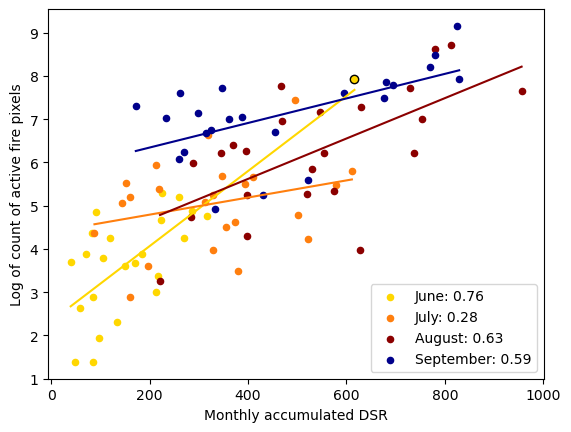

In [6]:
fig, ax = plt.subplots()

mcolours = {"6" : "gold", "7" : "tab:orange", "8" : "darkred", "9" : "darkblue", "10" : "tab:purple"}
mnames = {"6" : "June", "7" : "July", "8" : "August", "9" : "September", "10" : "October"}

for m in list(mcolours.keys())[:-1]:
    
    df_m = df.loc[(df.index.month == int(m))]#.loc[slice(None,"2023")]
    
    # coeffs of best fit & correlation coefficient
    a,b = np.polyfit(df_m.dsr, df_m.log_px,1)
    r = str(round(df_m.corr()["dsr"]["log_px"],2))
    
    df_m.plot(ax = ax, color = mcolours[m], kind = "scatter", x = "dsr", y = "log_px", label = mnames[m]+": "+r,
              xlabel = "Monthly accumulated DSR", ylabel = "Log of count of active fire pixels")
    
    xyline(df_m.dsr, df_m.log_px, color = mcolours[m], ax = ax)
    
#     df_x = df.loc[(df.index.month == int(m)) & (df.index.year < 2024)]
#     xyline(df_x.dsr, df_x.log_px, color = mcolours[m], ax = ax)
    
ax.scatter(df.loc["2024-06", "dsr"], df.loc["2024-06", "log_px"], color = mcolours["6"], marker = "o", ec = "k")

# June correlation excluding 2024 is 0.57; including 2024 is 0.76
plt.savefig("fig/dsr-activefire-correlation.png")

# DSR & sub-indices

In [75]:
ds = xr.open_dataset("data/fwi_daily_pantanal_era5.nc")
varbls = ["dsr","isi","bui","ffmc","dmc","dc"]
letters = ["a","b","c","d","e","f"]

qq = ds.rolling(time = 15).mean().sel(time = slice("1990","2020")).groupby("time.dayofyear").quantile(0.95)

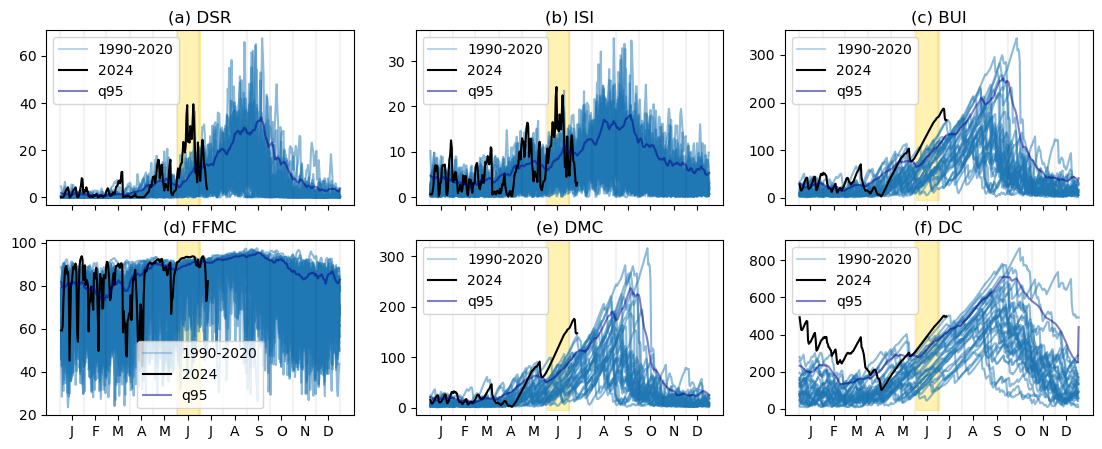

In [74]:
nc = 3; nr = 2

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (4.5*nc, 2.5*nr), dpi = 100, sharex = True)

for i in range(len(varbls)):
    
    ax = fig.axes[i]
    vnm = varbls[i]
    
    ts = ds[vnm]
    
    y = "2000"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, "tab:blue", alpha = 0.3, label = "1990-2020")
    for y in range(1990,2021):
        ts_y = ts.sel(time = str(y))
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")
        
#     y = "2020"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = y, lw = 1)
    y = "2024"; ts_y = ts.sel(time = str(y)); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = y)
    ax.set_title("("+letters[i]+") "+vnm.upper())
        
    ax.plot(qq.dayofyear, qq[vnm], color = "darkblue", label = "q95", alpha = 0.5)
    
    ax.legend()
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    
    ax.add_patch(Rectangle((ts.sel(time = "2024-06-01").time.dt.dayofyear.values,-5), 30, 1000, color = "gold", alpha = 0.3))
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
plt.savefig("fig/subindices_2024.png")

## Sub-subindices

In [97]:
ds = xr.open_dataset("data/vars_daily_pantanal_era5.nc")

# varbls = list(ds.data_vars); nc = 3; nr = 2
varbls = ["pr", "rh_mean", "sfcWind", "tmax"]; nc = 4; nr = 1
varnames = ["Rainfall", "Relative humidity", "Wind speed", "Daily max temperature"]
units = ["Precipitation (mm/day)", "Relative humidity (%)", "Wind speed (m/s)", "Temperature (°C)"]

qq = ds.rolling(time = 15).mean().sel(time = slice("1990","2020")).groupby("time.dayofyear").quantile([0.05,0.95])

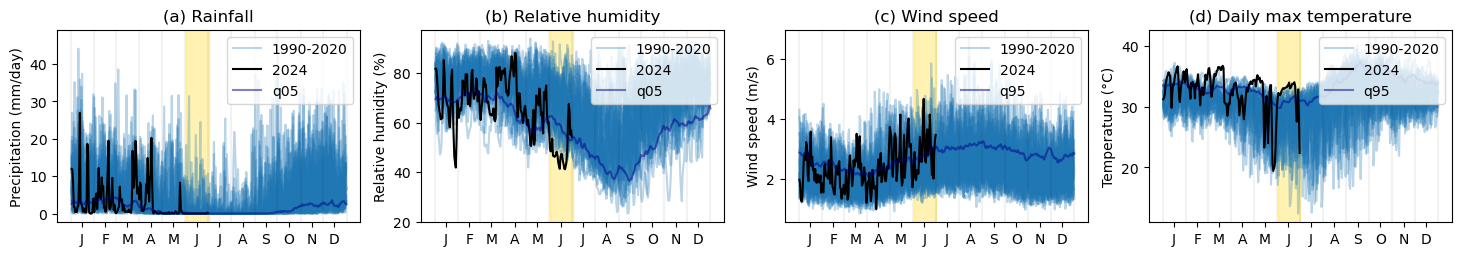

In [98]:
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (4.5*nc, 2.5*nr), dpi = 100, sharex = True)

for i in range(len(varbls)):
    
    ax = fig.axes[i]
    vnm = varbls[i]
    
    ts = ds[vnm]
    
    y = "1990"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, "tab:blue", alpha = 0.3, label = "1990-2020")
    for y in range(1991,2021):
        ts_y = ts.sel(time = str(y))
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.3, label = "_years")
        
#     y = "2020"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = y, lw = 1)
    y = "2024"; ts_y = ts.sel(time = str(y)); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = y)
    ax.set_title("("+letters[i]+") "+varnames[i])
    ax.set_ylabel(units[i])
    
    if vnm in ["sfcWind", "tmax"]:
        ax.plot(qq.dayofyear, qq[vnm].sel(quantile = 0.95), color = "darkblue", label = "q95", alpha = 0.5)
    else:
        ax.plot(qq.dayofyear, qq[vnm].sel(quantile = 0.05), color = "darkblue", label = "q05", alpha = 0.5)
    
    ax.legend(loc = "upper right")
        
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    
    ax.add_patch(Rectangle((ts.sel(time = "2024-06-01").time.dt.dayofyear.values,-5), 30, 1000, color = "gold", alpha = 0.3)) # 20-day period starting from July 1st
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
        
plt.savefig("fig/subsubindices_2024.png")

### Trends in variables over time

In [103]:
nm = 1

months = ["June", "May-June"][nm-1]

ds = xr.open_dataset("data/vars_daily_pantanal_era5.nc").resample(time = "MS").mean().rolling(time = nm).mean().groupby("time.month")[6]
ds["tmax"] = ds.tmax.assign_attrs(long_name = "Daily maximum temperature", units = "degC")
ds["sfcWind"] = ds.sfcWind.assign_attrs(long_name = "Wind speed")

varbls = ["pr", "rh_mean", "sfcWind", "tmax"]; nc = 4; nr = 1
varnames = ["Rainfall", "Relative humidity", "Wind speed", "Daily max temperature"]
units = ["Precipitation (mm/day)", "Relative humidity (%)", "Wind speed (m/s)", "Temperature (°C)"]

ds[varbls].assign_coords(time = ds.time.dt.year).rename(time = "year").to_dataframe().to_csv("data/era5-junevars.csv")

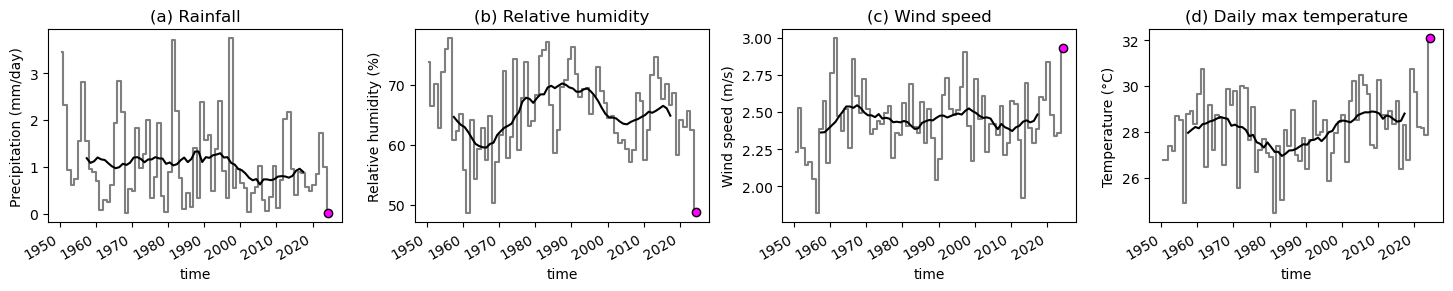

In [102]:
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (4.5*nc, 2.5*nr), dpi = 100, sharex = True)
plt.subplots_adjust(wspace = 0.25)

for i in range(len(varbls)):
    
    ax = fig.axes[i]
    vnm = varbls[i]
    
    ts = ds[vnm]
    ts.plot(ax = ax, drawstyle = "steps-mid", color = "k", alpha = 0.5)
    ax.scatter(ts.sel(time = "2024").time, ts.sel(time = "2024"), marker = "o", color = "magenta", edgecolor = "k", zorder = 99)
    ts.rolling(time = 15, center = True).mean().plot(ax = ax, color = "k")
#     ax.axvline(ts.sel(time = "1979").time, color = "tab:blue", ls = "--")
    ax.set_title("("+letters[i]+") "+varnames[i])
    ax.set_ylabel(units[i])
            
plt.savefig("fig/subsubindices_trends-"+months.lower()+".png")

# Relationship between monthly temperature & precip

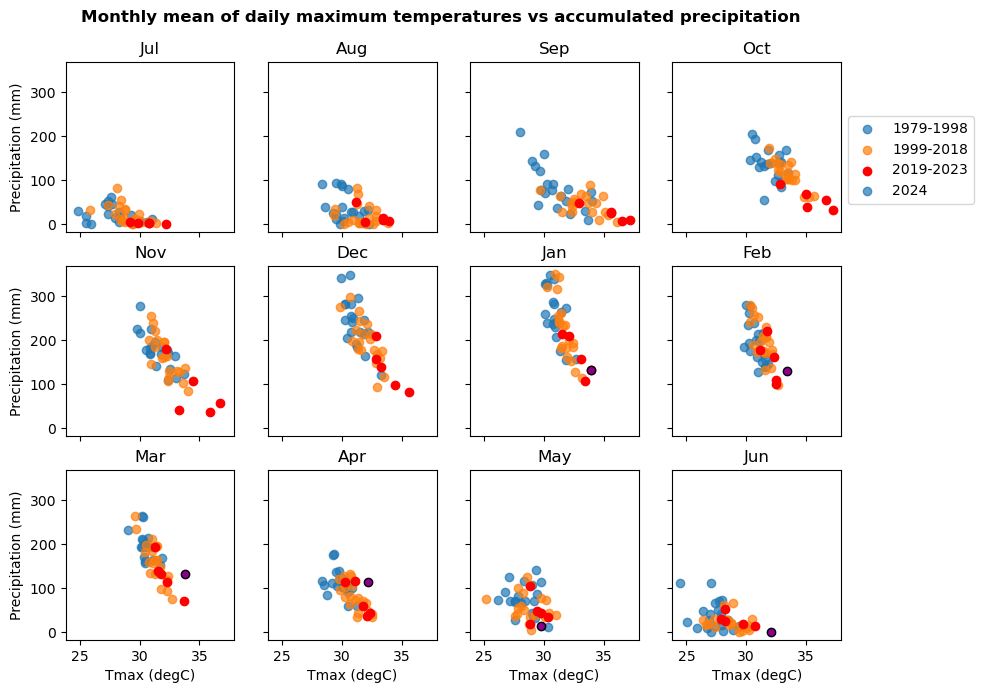

In [15]:
ds = xr.open_dataset("data/vars_daily_pantanal_era5.nc").resample(time = "MS").mean()

ds_c20 = ds.sel(time = slice("1979","1998"))
ds_c21 = ds.sel(time = slice("1999","2018"))
ds_recent = ds.sel(time = slice("2019", "2023"))

fig, axs = plt.subplots(ncols = 4, nrows = 3, figsize = (4*2.5, 3*2.5), sharex = True, sharey = True)

for i in range(12):
    ax = fig.axes[i]
    m = ((i+6) % 12)+1
    
    ndays = ds.sel(time = "2023").groupby("time.month")[m].time.dt.daysinmonth.values
    
    ax.scatter(ds_c20.groupby("time.month")[m].tmax, ds_c20.groupby("time.month")[m].pr * ndays, alpha = 0.7)
    ax.scatter(ds_c21.groupby("time.month")[m].tmax, ds_c21.groupby("time.month")[m].pr * ndays, alpha = 0.7)
    ax.scatter(ds_recent.groupby("time.month")[m].tmax, ds_recent.groupby("time.month")[m].pr * ndays, color = "red")
    if m <= 6: 
        ax.scatter(ds.sel(time = "2024").groupby("time.month")[m].tmax, ds.sel(time = "2024").groupby("time.month")[m].pr * ndays, color = "darkmagenta", edgecolor = "k")
    
    ax.set_title(ds_c20.isel(time = m-1).time.dt.strftime("%b").values)
    
for ax in axs[:,0]: ax.set_ylabel("Precipitation (mm)")
for ax in axs[-1,:]: ax.set_xlabel("Tmax (degC)")
fig.legend([str(da.time.dt.year.min().values)+"-"+str(da.time.dt.year.max().values) for da in [ds_c20, ds_c21, ds_recent]] + ["2024"], bbox_to_anchor = (0.9,0.75), loc = "center left")

plt.suptitle("Monthly mean of daily maximum temperatures vs accumulated precipitation", fontweight= "bold", y = 0.95)
plt.savefig("fig/monthly-pr-temp-distribution.png")

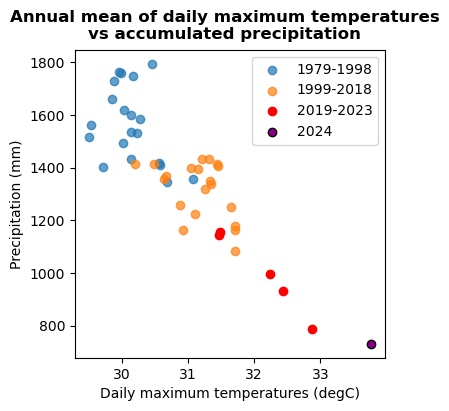

In [10]:
ds = xr.open_dataset("data/vars_daily_pantanal_era5.nc").resample(time = "AS-JUL", label = "right").mean()

ds_c20 = ds.sel(time = slice("1979","1998"))
ds_c21 = ds.sel(time = slice("1999","2018"))
ds_recent = ds.sel(time = slice("2019", "2023"))

fig, ax = plt.subplots(figsize = (4,4), sharex = True, sharey = True)

ax.scatter(ds_c20.tmax, ds_c20.pr*365, label = str(ds_c20.time.dt.year.min().values)+"-"+str(ds_c20.time.dt.year.max().values), alpha = 0.7)
ax.scatter(ds_c21.tmax, ds_c21.pr*365, label = str(ds_c21.time.dt.year.min().values)+"-"+str(ds_c21.time.dt.year.max().values), alpha = 0.7)
ax.scatter(ds_recent.tmax, ds_recent.pr*365, label = str(ds_recent.time.dt.year.min().values)+"-"+str(ds_recent.time.dt.year.max().values), color = "red")
ax.scatter(ds.sel(time = "2024").tmax, ds.sel(time = "2024").pr*365, label = "2024", color = "darkmagenta", edgecolor = "k")

ax.set_ylabel("Precipitation (mm)")
ax.set_xlabel("Daily maximum temperatures (degC)")
ax.legend()

plt.suptitle("Annual mean of daily maximum temperatures\nvs accumulated precipitation", fontweight = "bold")
plt.savefig("fig/annual-pr-temp-distribution.png")

In [11]:
df = ds[["tmax", "pr"]].to_dataframe()
df["pr"] = df["pr"] * 365
df.loc[slice("1979",None)].to_csv("tmax-pr.csv")

<AxesSubplot: xlabel='tmax', ylabel='pr'>

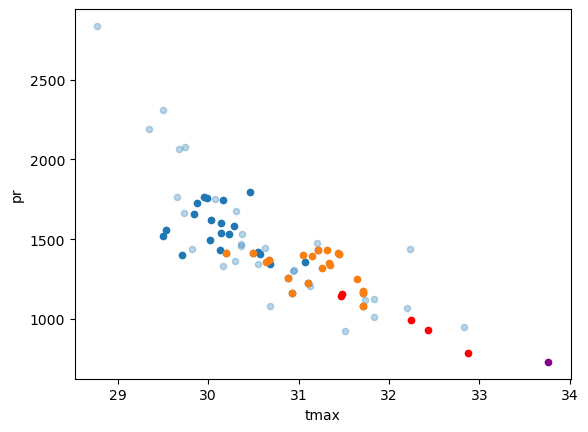

In [141]:
df.plot(kind = "scatter", x = "tmax", y = "pr", alpha = 0.3)

df.loc[slice("1979","2008")].plot(ax = plt.gca(), kind = "scatter", x = "tmax", y = "pr", color = "tab:blue")
df.loc[slice("1999","2018")].plot(ax = plt.gca(), kind = "scatter", x = "tmax", y = "pr", color = "tab:orange")
df.loc[slice("2019","2023")].plot(ax = plt.gca(), kind = "scatter", x = "tmax", y = "pr", color = "red")
df.loc["2024"].plot(ax = plt.gca(), kind = "scatter", x = "tmax", y = "pr", color = "darkmagenta")

# Map of DSR anomaly

In [143]:
dsr = xr.open_dataset("data/era5_dsr_-60_-54_-23_-15.nc").dsr.resample(time = "MS").sum().groupby("time.month")[6]
dsr_clim = dsr.sel(time = slice("1990", "2020")).mean("time")
dsr_2024 = dsr.sel(time = "2024-06-01")
dsr_anom = dsr_2024 - dsr_clim
dsr_relanom = (dsr_anom / dsr_clim) * 100

In [156]:
dsr_m = xr.open_dataset("data/era5_dsr_-60_-54_-23_-15.nc").dsr.resample(time = "MS").sum().sel(time = slice("1990","2020"))
rm = regionmask.mask_geopandas(sf, dsr.longitude, dsr.latitude)

In [157]:
dsr_m = dsr_m.where(rm == 0).mean(["longitude", "latitude"])

In [158]:
dsr_2024.where(rm == 0).mean()

<xarray.DataArray 'dsr' ()>
array(616.0928, dtype=float32)
Coordinates:
    time     datetime64[ns] 2024-06-01
Attributes: (12/29)
    GRIB_paramId:                             260540
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_ll
    ...                                       ...
    GRIB_shortName:                           fwinx
    GRIB_units:                               Numeric
    long_name:                                Forest fire weather index
    units:                                    Numeric
    standard_name:                            unknown
    note:                                     Intermediate data after 2024-01-01

In [163]:
dsr_m.groupby("time.month")[10].mean()

<xarray.DataArray 'dsr' ()>
array(136.31334, dtype=float32)
Attributes: (12/29)
    GRIB_paramId:                             260540
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_ll
    ...                                       ...
    GRIB_shortName:                           fwinx
    GRIB_units:                               Numeric
    long_name:                                Forest fire weather index
    units:                                    Numeric
    standard_name:                            unknown
    note:                                     Intermediate data after 2024-01-01

In [5]:
sf_tri = gpd.read_file("sf/pantanal-tri")
df = pd.read_csv("data/modis_conf-80.csv", parse_dates = ["acq_date"], index_col = "acq_date")
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(x=df.longitude, y=df.latitude), crs = "EPSG:4326").clip(sf.to_crs(epsg = 4326))

<xarray.DataArray 'dsr' ()>
array(110.827675, dtype=float32)
Attributes: (12/30)
    GRIB_paramId:                             260540
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_ll
    ...                                       ...
    GRIB_units:                               Numeric
    long_name:                                Forest fire weather index
    units:                                    Numeric
    standard_name:                            unknown
    note:                                     Intermediate data after 2024-01-01
    coordinates:                              time surface latitude longitude

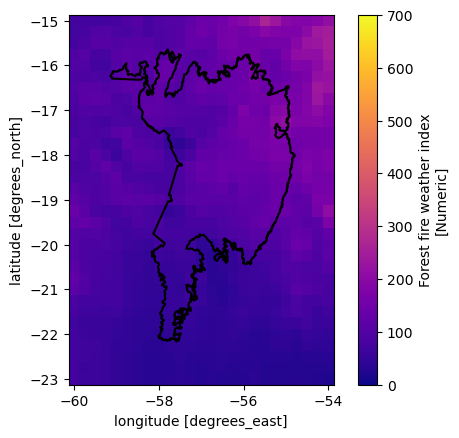

In [42]:
dsr_clim.plot(vmin = 0, vmax = 700, cmap = "plasma")
sf.boundary.plot(ax = plt.gca(), color = "k")
dsr_clim.where(regionmask.mask_geopandas(sf, dsr_clim.longitude, dsr_clim.latitude) == 0).mean(["latitude", "longitude"])

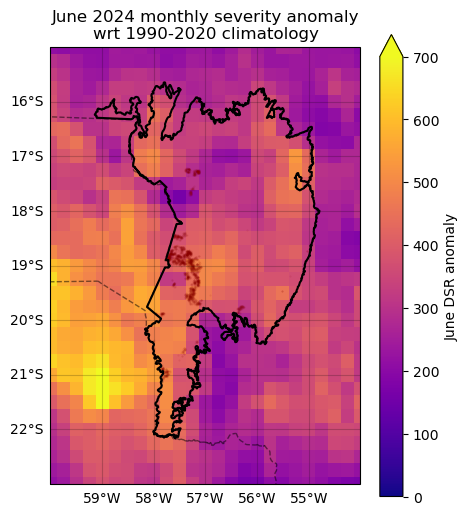

In [32]:
fig, ax = plt.subplots(ncols = 1, figsize = (5,6), subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})

dsr_anom.plot(ax = ax, vmin = 0, vmax = 700, cmap = "plasma", cbar_kwargs ={"label": "June DSR anomaly"})
ax.set_title("June 2024 monthly severity anomaly\nwrt 1990-2020 climatology")

ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
sf.boundary.plot(ax = ax, color = "k")
# sf_tri.boundary.plot(ax = ax, color = "k", ls = "--")
ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["bottom", "left"])

df.loc["2024-06"].plot(ax = ax, marker = ".", color = "darkred", alpha = 0.1, markersize = 0.75)

plt.savefig("fig/pantanal-tri.png")

In [34]:
dsr_anom.to_netcdf("dsr-anom_june-2024.nc")
df.loc["2024-06"].to_csv("active-fire-data.csv")

<GeoAxesSubplot: title={'center': 'June 2024 relative monthly severity anomaly\nwrt 1990-2020 climatology'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

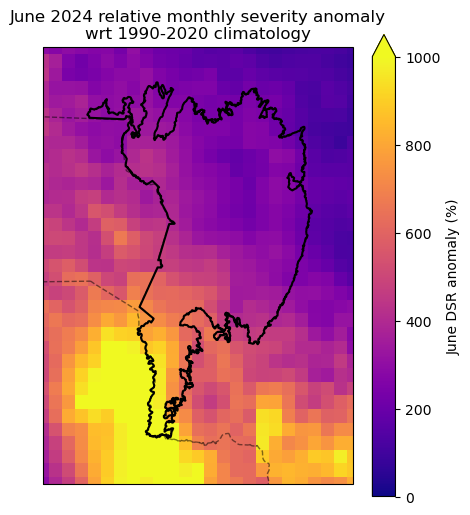

In [75]:
fig, ax = plt.subplots(ncols = 1, figsize = (5,6), subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})

dsr_relanom.plot(ax = ax, cmap = "plasma", vmin = 0, vmax = 1000, cbar_kwargs = {"label": "June DSR anomaly (%)"})
ax.set_title("June 2024 relative monthly severity anomaly\nwrt 1990-2020 climatology")

ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
sf.boundary.plot(ax = ax, color = "k")

# Map of annual precipitation anomaly

In [19]:
pr = wrap_lon(xr.open_dataset("data/era5_tp_daily_-60--54E_-23--15N_su.nc").tp.resample(time = "AS-JUL", label = "right").sum())

In [20]:
pr_clim = pr.sel(time = slice("1991","2020")).mean("time") # climatology: June 1990-July 2020
pr_2024 = pr.sel(time = "2024-07-01")
pr_anom = pr_2024 - pr_clim
pr_relanom = (pr_anom / pr_clim) * 100

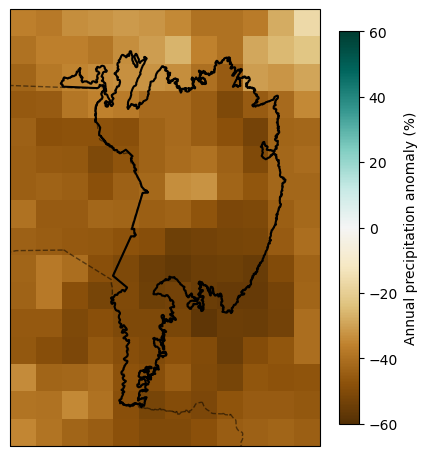

In [31]:
fig, ax = plt.subplots(ncols = 1, figsize = (5,6), subplot_kw = {"projection" : mapproj})

pr_relanom.plot(ax = ax, cmap = "BrBG", vmin = -60, vmax = 60, cbar_kwargs = {"label": "Annual precipitation anomaly (%)", "shrink" : 0.85})
sf.boundary.plot(ax = ax, color = "k")
ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
ax.set_title("")

plt.savefig("fig/pr-anomaly-2024.png")

# dsr_clim.where(regionmask.mask_geopandas(sf, dsr_clim.longitude, dsr_clim.latitude) == 0).mean(["latitude", "longitude"])

# Synthesis plots

In [2]:
def synth_plot(df, ax = None, logged = False):
    
    if not ax: fig, ax = plt.subplots(dpi = 100)
    
    gcols = {"obs" : "blue", 
             "obs_synth" : "blue", 
             "models" : "red", 
             "model_synth" : "red",
             "synth" : "magenta"}
    
    ax.grid(axis = "x", which = "major", color = "k", alpha = 0.1)
    
    if logged:
        ax.set_xscale('log')
        ax.axvline(1, ls = "--", color = "k", zorder = -99)
    else:
        ax.axvline(0, ls = "--", color = "k", zorder = -99)
    
    for k in range(len(df)):

        r = df.iloc[k]
        ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "white", lw = 1.5))
        ax.add_patch(Rectangle((r.lower,-k-0.4), r.upper - r.lower, 0.8, facecolor = gcols[r.name], alpha = 0.5 + 0.5*("synth" in r.name)))

        ax.plot(r.est, -k, color = "k", marker = "v")

    ax.set_yticks(range(0, -len(df), -1))
    ax.set_yticklabels(df.model)

In [3]:
varnm = "dsr-june"

In [4]:
synth = {a.lower()+"_"+b.lower() : pd.read_csv("synthesis/synth_"+varnm+"_"+a+"_"+b+".csv", index_col = "group") for a in ["dI","PR"] for b in ["attr","proj"]}

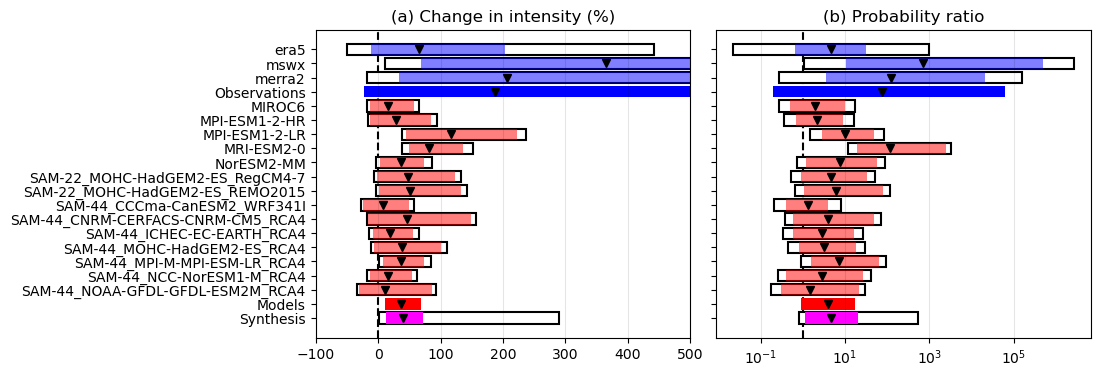

In [13]:
fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (10,len(synth["di_attr"])*0.2))
plt.subplots_adjust(wspace = 0.07)

synth_plot(synth["di_attr"], ax = axs[0])
axs[0].set_title("(a) Change in intensity (%)")
if varnm == "dsr-june": axs[0].set_xlim(-100,500)    

synth_plot(synth["pr_attr"], ax = axs[1], logged = True)
axs[1].set_title("(b) Probability ratio")
    
plt.savefig("fig/synthesis_"+varnm+"_attr.png")

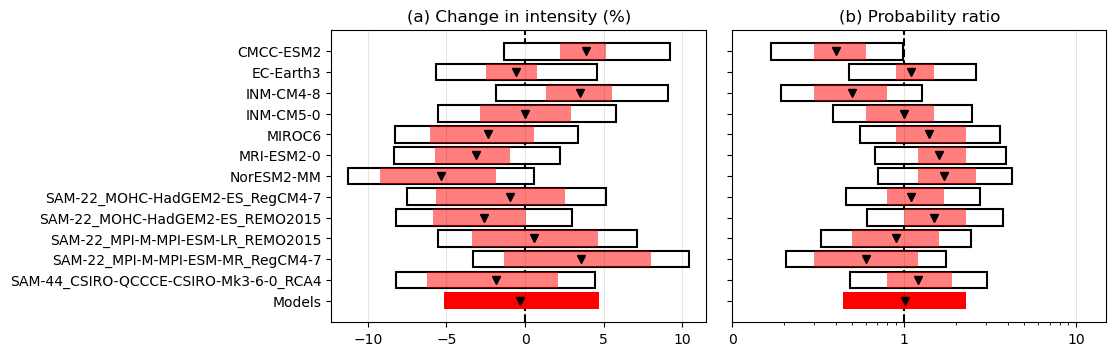

In [6]:
fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (10,len(synth["di_attr"])*0.2))
plt.subplots_adjust(wspace = 0.07)

synth_plot(synth["di_proj"], ax = axs[0])
axs[0].set_title("(a) Change in intensity (%)")

synth_plot(synth["pr_proj"], ax = axs[1], logged = True)
axs[1].set_title("(b) Probability ratio")
axs[1].xaxis.set_major_formatter(lambda x, pos: str(int(x)))
if varnm == "dsr-june": 
    axs[1].set_xlim(0.5,15)
else:
    axs[1].set_xlim(0.1,15)

# axs[1].xaxis.set_minor_formatter(lambda x, pos: str(int(x)))

plt.savefig("fig/synthesis_"+varnm+"_proj.png")

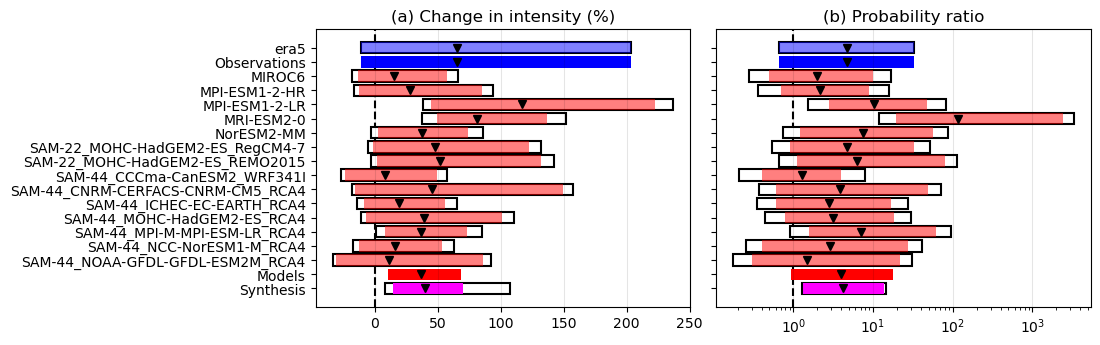

In [179]:
# version with ERA5 full series only
synth = {a.lower()+"_"+b.lower() : pd.read_csv("synthesis/appendix_synth_"+a+"_"+b+"_"+varnm+".csv", index_col = "group") for a in ["dI","PR"] for b in ["attr","proj"]}

fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (10,len(synth["di_attr"])*0.2))
plt.subplots_adjust(wspace = 0.07)

synth_plot(synth["di_attr"], ax = axs[0])
axs[0].set_title("(a) Change in intensity (%)")

synth_plot(synth["pr_attr"], ax = axs[1], logged = True)
axs[1].set_title("(b) Probability ratio")
    
plt.savefig("fig/app_synthesis_"+varnm+"_attr.png")

# DSR time series

In [19]:
data = [pd.read_csv("ts_obs/pantanal-fires_dsr-june_"+ds+".dat", sep = " ", comment = "#", header = None, names = ["year", ds.split("-")[0]], index_col = 0) for ds in ["era5", "mswx", "merra2-corrected"]]
ds_names = ["ERA5", "MSWX", "MERRA2"]

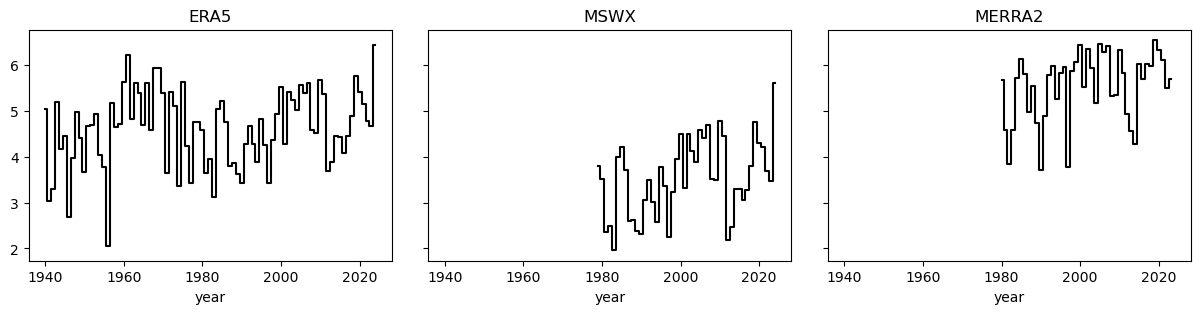

In [165]:
nc = 3
fig, axs = plt.subplots(ncols = nc, sharey = True, figsize = (nc * 5,3), sharex = True)
plt.subplots_adjust(wspace = 0.1)

for i in range(3):
    ax = axs[i]
    ts = np.log(data[i])
    
    ts.plot(ax = ax, drawstyle = "steps-mid", label = "_", color = "k", legend = False)
    ax.set_title(ds_names[i])
    
axs[0].set_xlabel()

<AxesSubplot: xlabel='year'>

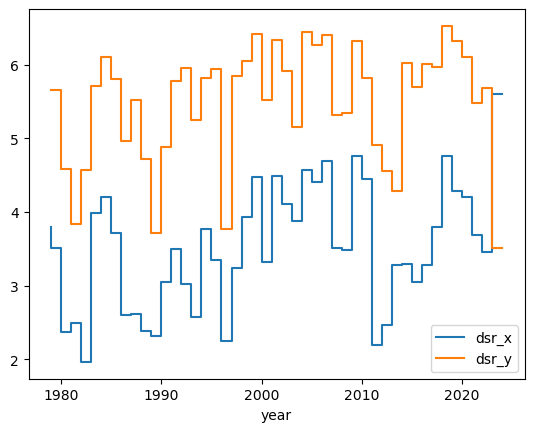

In [144]:
np.log(merge_byindex(data[1:])).plot(drawstyle = "steps", label = ["ERA5", "MSWX", "MERRA2"][1:])

In [27]:
np.log(merge_byindex(data)).corr(method = "spearman")

,era5,mswx,merra2
era5,1.000000,0.985446,0.821142
mswx,0.985446,1.000000,0.827343
merra2,0.821142,0.827343,1.000000


In [28]:
(merge_byindex(data)).corr(method = "spearman")

,era5,mswx,merra2
era5,1.000000,0.985446,0.821142
mswx,0.985446,1.000000,0.827343
merra2,0.821142,0.827343,1.000000


# Composite figures

## June DSR & correlation with active fire pixels

In [35]:
sf_tri = gpd.read_file("sf/pantanal-tri")
df = pd.read_csv("data/modis_conf-80.csv", parse_dates = ["acq_date"], index_col = "acq_date")
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(x=df.longitude, y=df.latitude), crs = "EPSG:4326").clip((xn,yn,xx,yx))

In [19]:
dsr = xr.open_dataset("data/era5_dsr_-60_-54_-23_-15.nc").dsr.resample(time = "MS").sum().groupby("time.month")[6]
dsr_clim = dsr.sel(time = slice("1990", "2020")).mean("time")
dsr_2024 = dsr.sel(time = "2024-06-01")
dsr_anom = dsr_2024 - dsr_clim
dsr_relanom = (dsr_anom / dsr_clim) * 100

In [91]:
dsr.where(regionmask.mask_geopandas(sf, dsr.longitude, dsr.latitude) == 0).mean(["longitude", "latitude"]).sel(time = slice("1990","2020")).mean()

<xarray.DataArray 'dsr' ()>
array(134.14479, dtype=float32)
Attributes: (12/29)
    GRIB_paramId:                             260540
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_ll
    ...                                       ...
    GRIB_shortName:                           fwinx
    GRIB_units:                               Numeric
    long_name:                                Forest fire weather index
    units:                                    Numeric
    standard_name:                            unknown
    note:                                     Intermediate data after 2024-01-01

In [29]:
# dataframe for correlations
dsr_era5 = xr.open_dataset("data/fwi_daily_pantanal_era5.nc").dsr.resample(time = "MS").sum().sel(time = slice(None, "2024-06"))
px_monthly = pd.read_csv("data/modis-active-pixels_pantanal.csv", index_col = "acq_date", parse_dates = ["acq_date"]).resample("MS").sum().loc[slice(None, "2024-06")]

px_monthly = merge_byindex([dsr_era5.to_dataframe(), px_monthly]).dropna(axis = 0, how = "any")
px_monthly["log_px"] = np.log(px_monthly.px)

mcolours = {"6" : "gold", "7" : "tab:orange", "8" : "darkred", "9" : "darkblue", "10" : "tab:purple"}
mnames = {"6" : "June", "7" : "July", "8" : "August", "9" : "September", "10" : "October"}

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/var/tmp/pbs.9849819.pbs/ipykernel_242363/3551054443.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  map_ax =  plt.subplot(121, projection = mapproj, extent = (xn,xx,yn,yx))


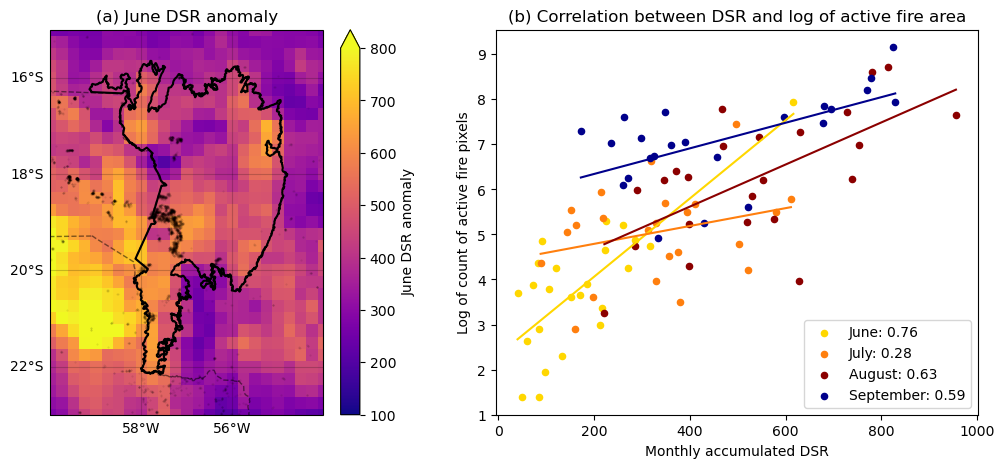

In [57]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,5), dpi = 100, gridspec_kw = {"width_ratios" : [1,1.4]})
plt.subplots_adjust(wspace = 0.25)

map_ax =  plt.subplot(121, projection = mapproj, extent = (xn,xx,yn,yx))
dsr_anom.plot(ax = map_ax, vmin = 100, vmax = 800, cmap = "plasma", cbar_kwargs ={"label": "June DSR anomaly"})
map_ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
sf.boundary.plot(ax = map_ax, color = "k")
# sf_tri.boundary.plot(ax = map_ax, color = "k", lw = 1)
map_ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["bottom", "left"], xlocs = range(-60,-52,2), ylocs = range(-22,-14,2))
df.loc["2024-06"].plot(ax = map_ax, marker = ".", color = "k", alpha = 0.1, markersize = 0.75)

map_ax.set_title("(a) June DSR anomaly")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ts_ax =  plt.subplot(122)

for m in list(mcolours.keys())[:-1]:
    
    df_m = px_monthly.loc[(px_monthly.index.month == int(m))]
    df_m.plot(ax = ts_ax, color = mcolours[m], kind = "scatter", x = "dsr", y = "log_px", label = mnames[m]+": "+str(round(df_m.corr()["dsr"]["log_px"],2)),
              xlabel = "Monthly accumulated DSR", ylabel = "Log of count of active fire pixels")
    xyline(df_m.dsr, df_m.log_px, color = mcolours[m], ax = ts_ax)
ts_ax.set_title("(b) Correlation between DSR and log of active fire area")

plt.savefig("fig/event-definition_dsr-correlation.png")

## Example of change in intensity plot for infographic

In [6]:
plt.bar([2000,2024,2060], height = [39.1 / 1.153, 39.1, 39.1*1.165], width = 5)
plt.ylabel("% change in June DSR since preindustrial climate")

## Temp vs precip & map of June 2024 12-month SPI

In [9]:
spi = xr.open_dataset("data/MERGE_CPTEC_spi_gamma_12.nc").sel(lon = slice(xn,xx), lat = slice(yn,yx), time = "2024-06").squeeze(drop = True).spi_gamma_12

In [21]:
ds = xr.open_dataset("data/vars_daily_pantanal_era5.nc").resample(time = "AS-JUL", label = "right").mean()

ds_c20 = ds.sel(time = slice("1979","1998"))
ds_c21 = ds.sel(time = slice("1999","2018"))
ds_recent = ds.sel(time = slice("2019", "2023"))

/var/tmp/pbs.9852197.pbs/ipykernel_1040367/860473138.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  map_ax =  plt.subplot(122, projection = mapproj, extent = (xn,xx,yn,yx))


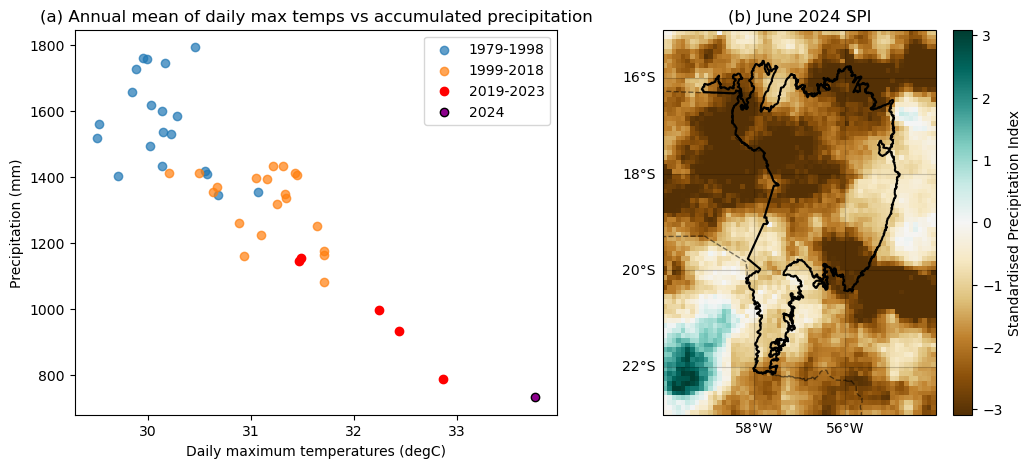

In [39]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,5), dpi = 100, gridspec_kw = {"width_ratios" : [1.4,1]})
plt.subplots_adjust(wspace = 0.25)

map_ax =  plt.subplot(122, projection = mapproj, extent = (xn,xx,yn,yx))
spi.plot(ax = map_ax, cmap = "BrBG", cbar_kwargs ={"label": "Standardised Precipitation Index"})
map_ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
sf.boundary.plot(ax = map_ax, color = "k")
# sf_tri.boundary.plot(ax = map_ax, color = "k", lw = 1)
map_ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["bottom", "left"], xlocs = range(-60,-52,2), ylocs = range(-22,-14,2))

map_ax.set_title("(b) June 2024 SPI")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ts_ax =  plt.subplot(121)

ts_ax.scatter(ds_c20.tmax, ds_c20.pr*365, label = str(ds_c20.time.dt.year.min().values)+"-"+str(ds_c20.time.dt.year.max().values), alpha = 0.7)
ts_ax.scatter(ds_c21.tmax, ds_c21.pr*365, label = str(ds_c21.time.dt.year.min().values)+"-"+str(ds_c21.time.dt.year.max().values), alpha = 0.7)
ts_ax.scatter(ds_recent.tmax, ds_recent.pr*365, label = str(ds_recent.time.dt.year.min().values)+"-"+str(ds_recent.time.dt.year.max().values), color = "red")
ts_ax.scatter(ds.sel(time = "2024").tmax, ds.sel(time = "2024").pr*365, label = "2024", color = "darkmagenta", edgecolor = "k")

ts_ax.set_ylabel("Precipitation (mm)")
ts_ax.set_xlabel("Daily maximum temperatures (degC)")
ts_ax.legend()
ts_ax.set_title("(a) Annual mean of daily max temps vs accumulated precipitation")

plt.savefig("fig/event-def_temp-pr_spi.png")

In [30]:
spi.where(regionmask.mask_geopandas(sf, spi.lon, spi.lat) == 0).mean()

<xarray.DataArray 'spi_gamma_12' ()>
array(-2.031367, dtype=float32)
Attributes:
    long_name:  Standardized Precipitation Index (Gamma distribution), 12-month
    valid_min:  -3.09
    valid_max:  3.09

## Temp vs precip & map of June 2024 precipitation anomaly

In [32]:
pr = wrap_lon(xr.open_dataset("data/era5_tp_daily_-60--54E_-23--15N_su.nc").tp.resample(time = "AS-JUL", label = "right").sum())

pr_clim = pr.sel(time = slice("1991","2020")).mean("time") # climatology: June 1990-July 2020
pr_2024 = pr.sel(time = "2024-07-01")
pr_anom = pr_2024 - pr_clim
pr_relanom = (pr_anom / pr_clim) * 100

In [21]:
ds = xr.open_dataset("data/vars_daily_pantanal_era5.nc").resample(time = "AS-JUL", label = "right").mean()

ds_c20 = ds.sel(time = slice("1979","1998"))
ds_c21 = ds.sel(time = slice("1999","2018"))
ds_recent = ds.sel(time = slice("2019", "2023"))

/var/tmp/pbs.9852197.pbs/ipykernel_1040367/1431819800.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  map_ax =  plt.subplot(122, projection = mapproj)


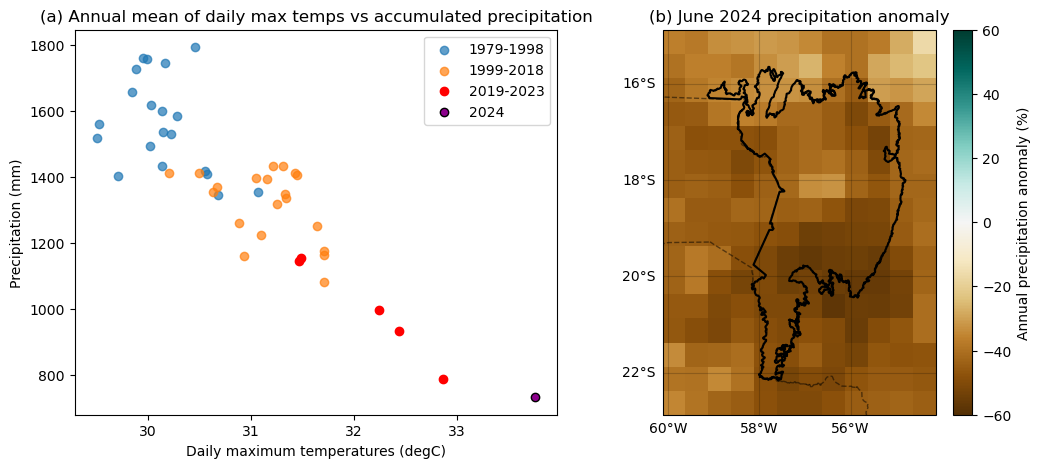

In [44]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,5), dpi = 100, gridspec_kw = {"width_ratios" : [1.4,1]})
plt.subplots_adjust(wspace = 0.25)

map_ax =  plt.subplot(122, projection = mapproj)
pr_relanom.plot(ax = map_ax, vmin = -60, vmax = 60, cmap = "BrBG", cbar_kwargs = {"label": "Annual precipitation anomaly (%)"})
map_ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
sf.boundary.plot(ax = map_ax, color = "k")
# sf_tri.boundary.plot(ax = map_ax, color = "k", lw = 1)
map_ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["bottom", "left"], xlocs = range(-60,-52,2), ylocs = range(-22,-14,2))

map_ax.set_title("(b) June 2024 precipitation anomaly")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ts_ax =  plt.subplot(121)

ts_ax.scatter(ds_c20.tmax, ds_c20.pr*365, label = str(ds_c20.time.dt.year.min().values)+"-"+str(ds_c20.time.dt.year.max().values), alpha = 0.7)
ts_ax.scatter(ds_c21.tmax, ds_c21.pr*365, label = str(ds_c21.time.dt.year.min().values)+"-"+str(ds_c21.time.dt.year.max().values), alpha = 0.7)
ts_ax.scatter(ds_recent.tmax, ds_recent.pr*365, label = str(ds_recent.time.dt.year.min().values)+"-"+str(ds_recent.time.dt.year.max().values), color = "red")
ts_ax.scatter(ds.sel(time = "2024").tmax, ds.sel(time = "2024").pr*365, label = "2024", color = "darkmagenta", edgecolor = "k")

ts_ax.set_ylabel("Precipitation (mm)")
ts_ax.set_xlabel("Daily maximum temperatures (degC)")
ts_ax.legend()
ts_ax.set_title("(a) Annual mean of daily max temps vs accumulated precipitation")

plt.savefig("fig/event-def_temp-pr_pr-anom.png")

In [40]:
pr_relanom.where(regionmask.mask_geopandas(sf, pr_relanom.lon, pr_relanom.lat) == 0).mean()

<xarray.DataArray 'tp' ()>
array(-46.32644, dtype=float32)
Coordinates:
    time     datetime64[ns] 2024-07-01
Attributes:
    long_name:  Precipitation
    units:      mm/day

In [43]:
pr_2024.sum() / pr_clim.sum()

<xarray.DataArray 'tp' ()>
array(0.5624368, dtype=float32)
Coordinates:
    time     datetime64[ns] 2024-07-01
Attributes:
    long_name:  Precipitation
    units:      mm/day

## Active fire pixels & burned area

In [4]:
px_daily = pd.read_csv("data/modis-active-pixels_pantanal.csv", index_col = "acq_date", parse_dates = ["acq_date"])

In [5]:
ba = pd.read_csv("data/PANTANAL_accumulated_20240101_20241204.csv", sep = ",", skiprows = 5, index_col = 0) / 1e6

In [6]:
def plot_ba(y, ax, **kwargs):
    
    ts_y = ba.loc[[str(y)]].transpose().iloc[:-1]
    ts_y.index = [datetime(y,int(d[-2:]),int(d[:2])) for d in ts_y.index]
    ax.plot(ts_y.index.dayofyear, ts_y, **kwargs)
    
def plot_px(y, ax, **kwargs):
    ts_y = px_daily.loc[str(y)]
    ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), **kwargs)

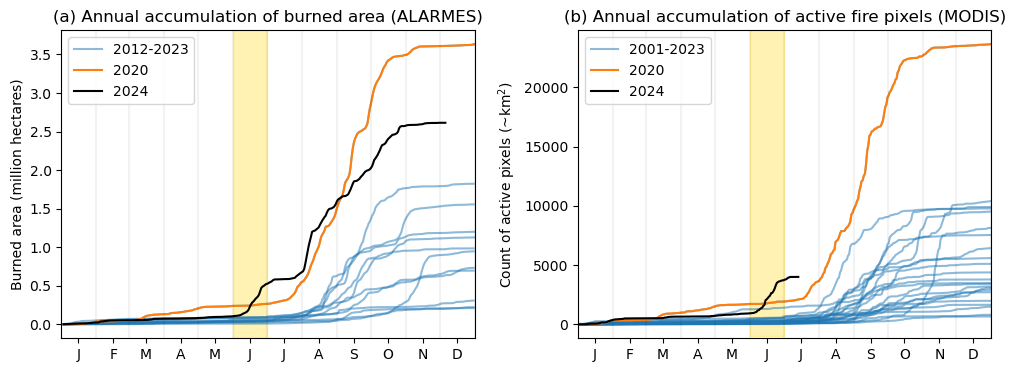

In [7]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)
plt.subplots_adjust(wspace = 0.25)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[0]

plot_ba(2012, ax = ax, color = "tab:blue", alpha = 0.5, label = "2012-2023")
for y in range(2013,2024): plot_ba(y, ax = ax, color = "tab:blue", alpha = 0.5, label = "_")
plot_ba(2020, ax = ax, color = "tab:orange", label = "2020")
plot_ba(2024, ax = ax, color = "k", label = "2024")

ax.set_ylabel("Burned area (million hectares)")
ax.set_title("(a) Annual accumulation of burned area (ALARMES)")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[1]

plot_px(2001, ax = ax, color = "tab:blue", alpha = 0.5, label = "2001-2023")
for y in range(2002,2024): plot_px(y, ax = ax, color = "tab:blue", alpha = 0.5, label = "_")
plot_px(2020, ax = ax, color = "tab:orange", label = "2020")
plot_px(2024, ax = ax, color = "k", label = "2024")

ax.set_ylabel("Count of active pixels (~km$^2$)")

ax.set_title("(b) Annual accumulation of active fire pixels (MODIS)")


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for ax in axs:
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    ax.set_xlim(0,366)

    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    ax.add_patch(Rectangle((152,-1000), 30, 1000000, color = "gold", alpha = 0.3))
    ax.legend()
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plt.savefig("fig/intro_active-fire-area.png")

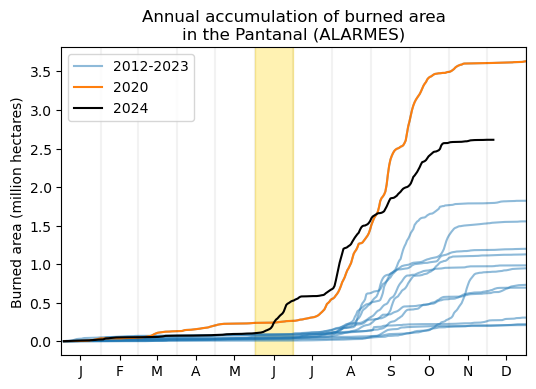

In [17]:
fig, axs = plt.subplots(ncols = 1, figsize = (6,4), dpi = 100)
plt.subplots_adjust(wspace = 0.25)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs

plot_ba(2012, ax = ax, color = "tab:blue", alpha = 0.5, label = "2012-2023")
for y in range(2013,2024): plot_ba(y, ax = ax, color = "tab:blue", alpha = 0.5, label = "_")
plot_ba(2020, ax = ax, color = "tab:orange", label = "2020")
plot_ba(2024, ax = ax, color = "k", label = "2024")

ax.set_ylabel("Burned area (million hectares)")
ax.set_title("Annual accumulation of burned area\nin the Pantanal (ALARMES)")

for ax in [axs]:
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    ax.set_xlim(0,366)

    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    ax.add_patch(Rectangle((152,-1000), 30, 1000000, color = "gold", alpha = 0.3))
    ax.legend()